# TensorNetworks in Neural Networks.

Here, we have a small toy example of how to use a TN inside of a fully connected neural network.

First off, let's install tensornetwork

In [62]:
# !pip install tensornetwork

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
# Import tensornetwork
import tensornetwork as tn
import random
import time
# Set the backend to tesorflow
# (default is numpy)
tn.set_default_backend("tensorflow")
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

# TensorNetwork layer definition

Here, we define the TensorNetwork layer we wish to use to replace the fully connected layer. Here, we simply use a 2 node Matrix Product Operator network to replace the normal dense weight matrix.

We TensorNetwork's NCon API to keep the code short.

In [63]:
class TNLayer(tf.keras.layers.Layer):

  def __init__(self):
    super(TNLayer, self).__init__()
    # Create the variables for the layer.
    self.a_var = tf.Variable(tf.random.normal(shape=(32, 32, 2),
                                              stddev=1.0/32.0),
                             name="a", trainable=True)
    self.b_var = tf.Variable(tf.random.normal(shape=(32, 32, 2),
                                              stddev=1.0/32.0),
                             name="b", trainable=True)
    self.bias = tf.Variable(tf.zeros(shape=(32, 32)),
                            name="bias", trainable=True)

  def call(self, inputs):
    # Define the contraction.
    # We break it out so we can parallelize a batch using
    # tf.vectorized_map (see below).
    def f(input_vec, a_var, b_var, bias_var):
      # Reshape to a matrix instead of a vector.
      input_vec = tf.reshape(input_vec, (32, 32))

      # Now we create the network.
      a = tn.Node(a_var)
      b = tn.Node(b_var)
      x_node = tn.Node(input_vec)
      a[1] ^ x_node[0]
      b[1] ^ x_node[1]
      a[2] ^ b[2]

      # The TN should now look like this
      #   |     |
      #   a --- b
      #    \   /
      #      x

      # Now we begin the contraction.
      c = a @ x_node
      result = (c @ b).tensor

      # To make the code shorter, we also could've used Ncon.
      # The above few lines of code is the same as this:
      # result = tn.ncon([x, a_var, b_var], [[1, 2], [-1, 1, 3], [-2, 2, 3]])

      # Finally, add bias.
      return result + bias_var

    # To deal with a batch of items, we can use the tf.vectorized_map
    # function.
    # https://www.tensorflow.org/api_docs/python/tf/vectorized_map
    result = tf.vectorized_map(
        lambda vec: f(vec, self.a_var, self.b_var, self.bias), inputs)
    return tf.nn.relu(tf.reshape(result, (-1, 1024)))

# Smaller model
These two models are effectively the same, but notice how the TN layer has nearly 10x fewer parameters.

In [64]:
Dense = tf.keras.layers.Dense
fc_model = tf.keras.Sequential(
    [
     tf.keras.Input(shape=(2,)),
     Dense(1024, activation=tf.nn.relu),
     Dense(1024, activation=tf.nn.relu),
     Dense(1, activation=None)])
fc_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_25 (Dense)            (None, 1024)              3072      
                                                                 
 dense_26 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_27 (Dense)            (None, 1)                 1025      
                                                                 
Total params: 1053697 (4.02 MB)
Trainable params: 1053697 (4.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [65]:
tn_model = tf.keras.Sequential(
    [
     tf.keras.Input(shape=(2,)),
     Dense(1024, activation=tf.nn.relu),
     # Here, we replace the dense layer with our MPS.
     TNLayer(),
     TNLayer(),
     TNLayer(),
     Dense(1, activation=None)])
tn_model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 1024)              3072      
                                                                 
 tn_layer_15 (TNLayer)       (None, 1024)              5120      
                                                                 
 tn_layer_16 (TNLayer)       (None, 1024)              5120      
                                                                 
 tn_layer_17 (TNLayer)       (None, 1024)              5120      
                                                                 
 dense_29 (Dense)            (None, 1)                 1025      
                                                                 
Total params: 19457 (76.00 KB)
Trainable params: 19457 (76.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Training a model

You can train the TN model just as you would a normal neural network model! Here, we give an example of how to do it in Keras.

In [66]:
X = np.concatenate([np.random.randn(20, 2) + np.array([3, 3]),
                    np.random.randn(20, 2) + np.array([-3, -3]),
                    np.random.randn(20, 2) + np.array([-3, 3]),
                    np.random.randn(20, 2) + np.array([3, -3])])

Y = np.concatenate([np.ones((40)), -np.ones((40))])

In [67]:
seconds = time.time()
print("Time in seconds since beginning of run:", seconds)
local_time = time.ctime(seconds)
print(local_time)

Time in seconds since beginning of run: 1710203740.1449122
Tue Mar 12 00:35:40 2024


In [68]:
tn_model.compile(optimizer="adam", loss="mean_squared_error")
tn_model.fit(X, Y, epochs=300, verbose=2, batch_size=16)

Epoch 1/300
5/5 - 2s - loss: 1.0046 - 2s/epoch - 321ms/step
Epoch 2/300
5/5 - 0s - loss: 1.0019 - 18ms/epoch - 4ms/step
Epoch 3/300
5/5 - 0s - loss: 1.0014 - 17ms/epoch - 3ms/step
Epoch 4/300
5/5 - 0s - loss: 0.9993 - 16ms/epoch - 3ms/step
Epoch 5/300
5/5 - 0s - loss: 0.9982 - 17ms/epoch - 3ms/step
Epoch 6/300
5/5 - 0s - loss: 0.9902 - 16ms/epoch - 3ms/step
Epoch 7/300
5/5 - 0s - loss: 0.9582 - 17ms/epoch - 3ms/step
Epoch 8/300
5/5 - 0s - loss: 0.8429 - 18ms/epoch - 4ms/step
Epoch 9/300
5/5 - 0s - loss: 0.4702 - 17ms/epoch - 3ms/step
Epoch 10/300
5/5 - 0s - loss: 0.1345 - 18ms/epoch - 4ms/step
Epoch 11/300
5/5 - 0s - loss: 0.0571 - 17ms/epoch - 3ms/step
Epoch 12/300
5/5 - 0s - loss: 0.0574 - 17ms/epoch - 3ms/step
Epoch 13/300
5/5 - 0s - loss: 0.0353 - 17ms/epoch - 3ms/step
Epoch 14/300
5/5 - 0s - loss: 0.0158 - 17ms/epoch - 3ms/step
Epoch 15/300
5/5 - 0s - loss: 0.0204 - 17ms/epoch - 3ms/step
Epoch 16/300
5/5 - 0s - loss: 0.0110 - 17ms/epoch - 3ms/step
Epoch 17/300
5/5 - 0s - loss: 0.0

14/14 [==============================] - 0s 3ms/step


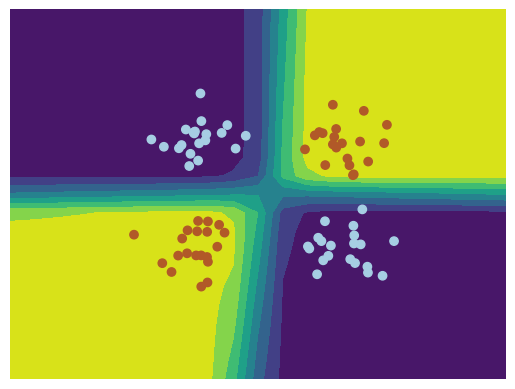

In [69]:
# Plotting code, feel free to ignore.
h = 1.0
x_min, x_max = X[:, 0].min() - 5, X[:, 0].max() + 5
y_min, y_max = X[:, 1].min() - 5, X[:, 1].max() + 5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# here "model" is your model's prediction (classification) function
Z = tn_model.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z)
plt.axis('off')

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.Paired)

In [70]:
seconds = time.time()
print("Time in seconds since end of run:", seconds)
local_time = time.ctime(seconds)
print(local_time)

Time in seconds since end of run: 1710203752.6563952
Tue Mar 12 00:35:52 2024


In [71]:
seconds = time.time()
print("Time in seconds since beginning of run:", seconds)
local_time = time.ctime(seconds)
print(local_time)

Time in seconds since beginning of run: 1710203752.6652684
Tue Mar 12 00:35:52 2024


# VS Fully Connected

Epoch 1/300
5/5 - 1s - loss: 0.4406 - 606ms/epoch - 121ms/step
Epoch 2/300
5/5 - 0s - loss: 0.1901 - 36ms/epoch - 7ms/step
Epoch 3/300
5/5 - 0s - loss: 0.1373 - 34ms/epoch - 7ms/step
Epoch 4/300
5/5 - 0s - loss: 0.1200 - 31ms/epoch - 6ms/step
Epoch 5/300
5/5 - 0s - loss: 0.1039 - 36ms/epoch - 7ms/step
Epoch 6/300
5/5 - 0s - loss: 0.0997 - 30ms/epoch - 6ms/step
Epoch 7/300
5/5 - 0s - loss: 0.1033 - 33ms/epoch - 7ms/step
Epoch 8/300
5/5 - 0s - loss: 0.0823 - 35ms/epoch - 7ms/step
Epoch 9/300
5/5 - 0s - loss: 0.0681 - 35ms/epoch - 7ms/step
Epoch 10/300
5/5 - 0s - loss: 0.0794 - 34ms/epoch - 7ms/step
Epoch 11/300
5/5 - 0s - loss: 0.0635 - 34ms/epoch - 7ms/step
Epoch 12/300
5/5 - 0s - loss: 0.0555 - 33ms/epoch - 7ms/step
Epoch 13/300
5/5 - 0s - loss: 0.0501 - 35ms/epoch - 7ms/step
Epoch 14/300
5/5 - 0s - loss: 0.0496 - 34ms/epoch - 7ms/step
Epoch 15/300
5/5 - 0s - loss: 0.0540 - 38ms/epoch - 8ms/step
Epoch 16/300
5/5 - 0s - loss: 0.0629 - 37ms/epoch - 7ms/step
Epoch 17/300
5/5 - 0s - loss: 

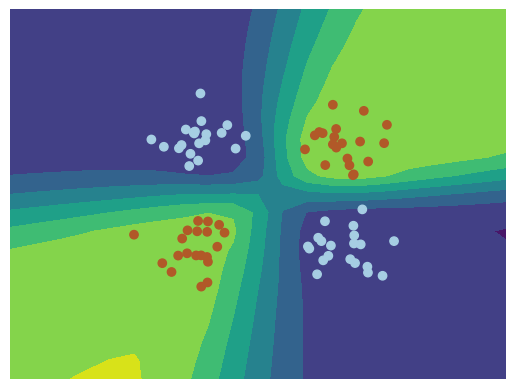

In [72]:
fc_model.compile(optimizer="adam", loss="mean_squared_error")
fc_model.fit(X, Y, epochs=300, verbose=2, batch_size=16)
# Plotting code, feel free to ignore.
h = 1.0
x_min, x_max = X[:, 0].min() - 5, X[:, 0].max() + 5
y_min, y_max = X[:, 1].min() - 5, X[:, 1].max() + 5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# here "model" is your model's prediction (classification) function
Z = fc_model.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z)
plt.axis('off')

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.Paired)

In [73]:
seconds = time.time()
print("Time in seconds since end of run:", seconds)
local_time = time.ctime(seconds)
print(local_time)

Time in seconds since end of run: 1710203764.265952
Tue Mar 12 00:36:04 2024
